# Bank Marketing - Case Study
&emsp; by Onkar Suhas Samant

# Executive Summary 

This case study aims to increase the efficiency of the marketing campaign by predicting whether the client will subscribe to a term deposit. Furthermore, we try to do inferential analysis to find out the potential factors for a successful campaign. <br>
The study is divided into the following 3 parts:
- Exploratory Data analysis 
- Inferential Analysis and Feature Selection
- Predictive Modeling

**Metric:** Precision-Recall Area Under Curve and F1-Score are the metrics used to compare different predictive models. <Br>
Since the banks need to identify potential clients who would subscribe to a term deposit we focus on the class "yes" for term deposit i.e. people who have subscribed. <br> 

Following is the summary of various models: 

| Model | PR-AUC |F1-Score|
| :-: | :-: |:-: |
|Null - No Features| 0.16|0.20|
| Decision Tree | 0.48 | 0.46|
| Logistic Regression | 0.40 |0.47|
| Random Forest | 0.35 |0.48|
| AdaBoost | 0.49 |0.46|
| K-Nearest Neighbors| 0.30|0.37|
| XGBoost | 0.43 |0.50|

- AdaBoost performs the best overall
- XGBoost gives the best F1-Score


    
**Next Steps:**
- Different metric: Asymmetric misclassification rate can be used with more weightage to false negatives compared to false positives and finding the model with the least asymmetric misclassification rate. False negatives are costlier for the bank as it cannot miss out on a potential client who might subscribe for a term deposit
- More Models: Neural Networks and SVM can be tried on the data for comparison purposes. 


# Importing libraries and data

In [35]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, make_scorer, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
bank_df = pd.read_csv("bank-additional-full.csv", sep = ";")

In [3]:
bank_df["education"].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

# Exploratory data analysis & Feature engineering

## Dataset information from UCI 

UCI has given information about the data and features. We need to understand it thoroughly before we do any analysis.

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. Following is the link:

[Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. <br>
Following are the attributes and their types: <br>
- **age:** continuous <br>
- **job:** categorical  <br>
- **marital:** categorical, values - divorced, married, single, unknown
- **education:** categorical, values - basic.4y , basic.6y, basic.9y , high.school, illiterate, professional.course, university.degree, unknown <br>
- **default:** categorical, has credit in default, values - no, yes, unknown<br>
- **housing:** categorical, has housing loan, values - no, yes, unknown <br>
- **loan:** categorical, has personal loan, values - no, yes, unknown <br>
- **contact:** categorical, values - cellular,telephone  <br>
- **month:** categorical, values - jan to dec <br>
- **day_of_week:** categorical, values - mon to fri <br>
- **duration:** continuous, last contact duration <br>
- **campaign:** continuous, number of contacts performed during this campaign and for this client <br>
- **pdays:** continuous,  number of days that passed by after the client was last contacted from a previous campaign. 999 means client was not previously contacted<br>
- **previous:** continuous, number of contacts performed before this campaign and for this client  <br>
- **poutcome:** categorical, outcome of the previous marketing campaign, values - failure, nonexistent,success
- **emp.var.rate:**
- **cons.price.idx:** continuous, consumer price index - monthly indicator
- **cons.conf.idx:** continuous, consumer confidence index - monthly indicator
- **euribor3m:** continuous, euribor 3 month rate - daily indicator
- **nr.employed:** continuous, number of employees - quarterly indicator <br>
Output variable (desired target):
- **y:** has the client subscribed a term deposit? (binary: 'yes','no')

##  High-level overview

### Null/Missing Values

In [4]:
np.sum(bank_df.isna())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no null values.

### Describe Variables

#### Continuous Variables

In [5]:
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Observations:** <br>
1) Age of all the individuals is **>17** <br>
2) Duration of the call varies a lot with **50% calls less than 3 minutes**, since we do not know the duration beforehand we drop the variable later <br>
3) Most clients in the data have been **contacted for the first time** as we see from pdays and previous values <br>
4) The consumer price index of less than 100 for all values shows there is **drop in inflation w.r.t. to the base year** <br>
5) **Consumer confidence index shows all negative values**

#### Categorical Variables

In [6]:
bank_df.describe(include = ["O"])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


**Observations:** <br>
1) Most common job is **admin.** <br>
2) Most of the people in the data are **married** <br>
3) As expected most of the people have **not defaulted** <br>
4) Most of the people have a **housing loan** <br>
5) Most common way of contacting people is through a **cellular device** <br>
6) Most of the calls were made in the month of **May** <br>
7) Since most of the calls are made for the first time, **poutcome has nonexistent as the most common value** <br>
8) The outcome variable y has most of the values as no, **indicating an unbalanced dataset** 

## Analysing variables and Encoding

In [7]:
#Saving the original dataframe before any changes 
bank_df2 = bank_df.copy()

### Continuous variables 

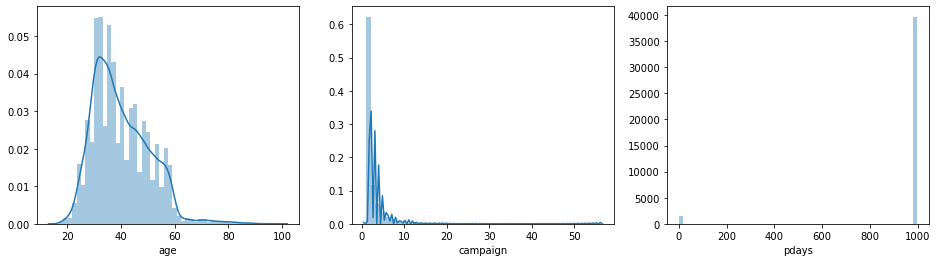

In [8]:
fig, ax = plt.subplots(1,3, figsize = (16,4))
sns.distplot(bank_df["age"], ax = ax[0])
sns.distplot(bank_df["campaign"], ax = ax[1])
sns.distplot(bank_df["pdays"], kde = 0, ax = ax[2]);

pdays has just 2 values and since we already have previous attribute, we can drop pdays

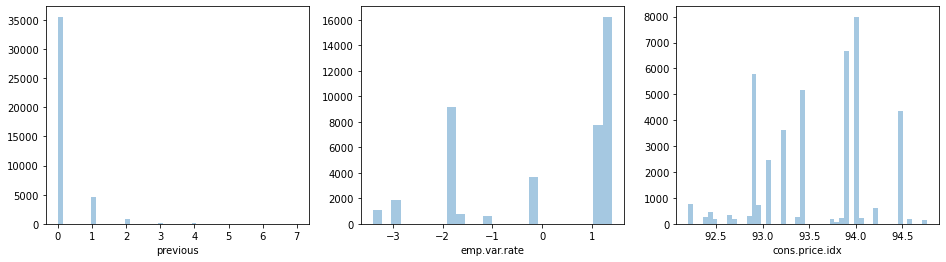

In [9]:
fig, ax = plt.subplots(1,3, figsize = (16,4))
sns.distplot(bank_df["previous"], kde = 0, ax = ax[0])
sns.distplot(bank_df["emp.var.rate"], kde = 0, ax = ax[1])
sns.distplot(bank_df["cons.price.idx"], kde = 0, ax = ax[2]);

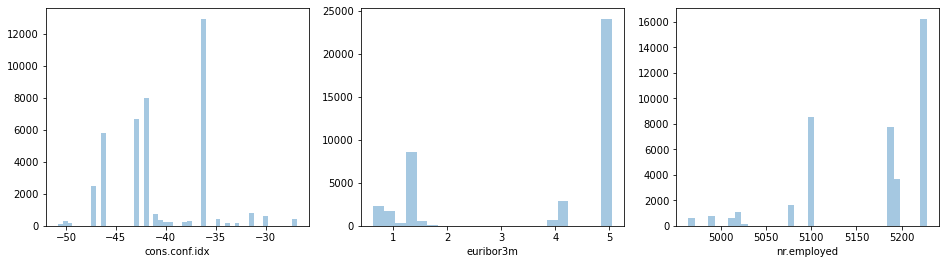

In [10]:
fig, ax = plt.subplots(1,3, figsize = (16,4))
sns.distplot(bank_df["cons.conf.idx"], kde = 0, ax = ax[0])
sns.distplot(bank_df["euribor3m"], kde = 0, ax = ax[1])
sns.distplot(bank_df["nr.employed"], kde = 0, ax = ax[2]);

### Categorical Variables

We check the counts of different variables, we do not encode it so as to not lose information

#### Job and Marital-status

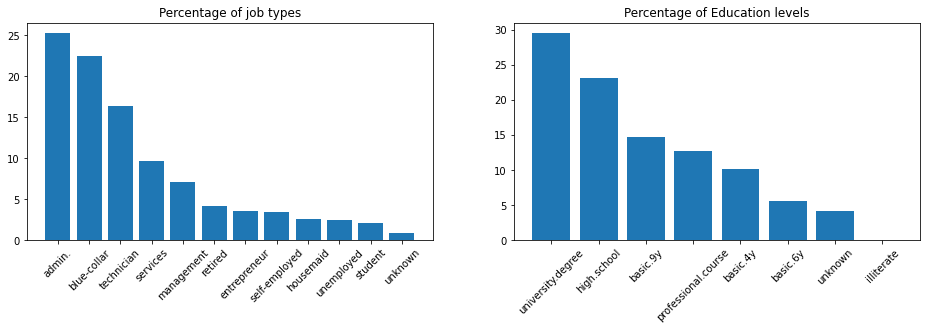

In [11]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].bar(x = bank_df["job"].value_counts(normalize = True).index, height= bank_df["job"].value_counts(normalize = True)*100)
ax[0].tick_params('x',labelrotation=45)
ax[0].set_title("Percentage of job types")
ax[1].bar(x = bank_df["education"].value_counts(normalize = True).index, height= bank_df["education"].value_counts(normalize = True)*100)
ax[1].tick_params('x',labelrotation=45)
ax[1].set_title("Percentage of Education levels");

#### Education and Default

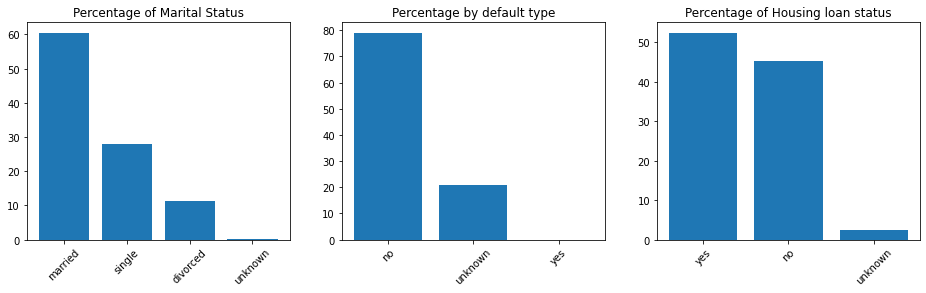

In [12]:
fig, ax = plt.subplots(1,3,figsize = (16,4))
ax[0].bar(x = bank_df["marital"].value_counts(normalize = True).index, height= bank_df["marital"].value_counts(normalize = True)*100)
ax[0].tick_params('x',labelrotation=45)
ax[0].set_title("Percentage of Marital Status")
ax[1].bar(x = bank_df["default"].value_counts(normalize = True).index, height= bank_df["default"].value_counts(normalize = True)*100)
ax[1].tick_params('x',labelrotation=45)
ax[1].set_title("Percentage by default type")
ax[2].bar(x = bank_df["housing"].value_counts(normalize = True).index, height= bank_df["housing"].value_counts(normalize = True)*100)
ax[2].tick_params('x',labelrotation=45)
ax[2].set_title("Percentage of Housing loan status");

#### Housing loan and Personal loan

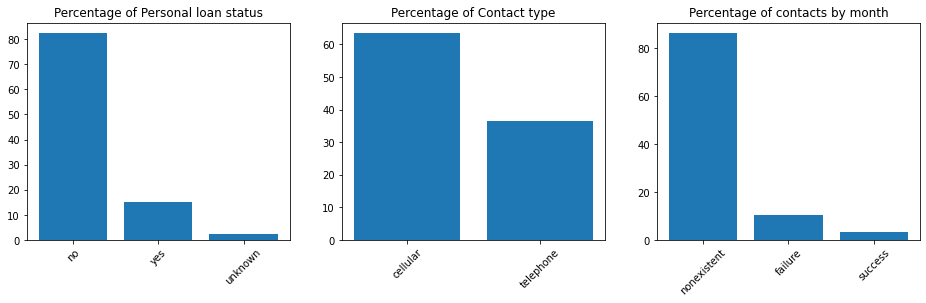

In [13]:
fig, ax = plt.subplots(1,3,figsize = (16,4))
ax[0].bar(x = bank_df["loan"].value_counts(normalize = True).index, height= bank_df["loan"].value_counts(normalize = True)*100)
ax[0].tick_params('x',labelrotation=45)
ax[0].set_title("Percentage of Personal loan status")
ax[1].bar(x = bank_df["contact"].value_counts(normalize = True).index, height= bank_df["contact"].value_counts(normalize = True)*100)
ax[1].tick_params('x',labelrotation=45)
ax[1].set_title("Percentage of Contact type")
ax[2].bar(x = bank_df["poutcome"].value_counts(normalize = True).index, height= bank_df["poutcome"].value_counts(normalize = True)*100)
ax[2].tick_params('x',labelrotation=45)
ax[2].set_title("Percentage of contacts by month");

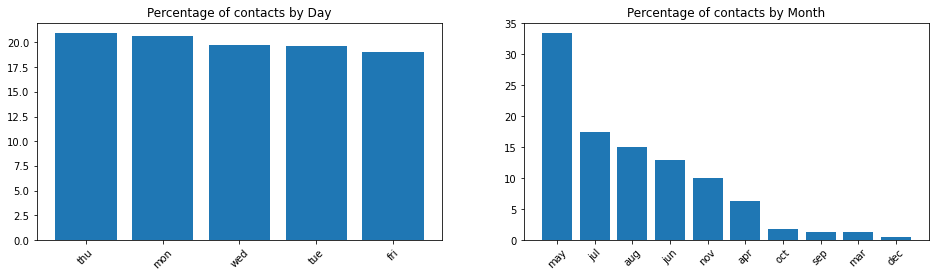

In [14]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].bar(x = bank_df["day_of_week"].value_counts(normalize = True).index, height= bank_df["day_of_week"].value_counts(normalize = True)*100)
ax[0].tick_params('x',labelrotation=45)
ax[0].set_title("Percentage of contacts by Day")
ax[1].bar(x = bank_df["month"].value_counts(normalize = True).index, height= bank_df["month"].value_counts(normalize = True)*100)
ax[1].tick_params('x',labelrotation=45)
ax[1].set_title("Percentage of contacts by Month");

#### Class (Y)

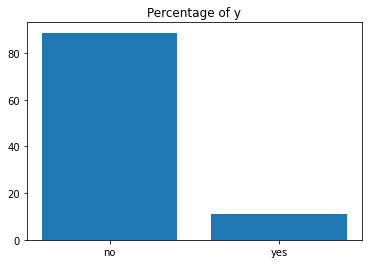

In [15]:
plt.figure(figsize = (6,4))
plt.bar(x = bank_df["y"].value_counts(normalize = True).index, height= bank_df["y"].value_counts(normalize = True)*100)
plt.title("Percentage of y");

## Dropping variables 

In this section, we drop variables which have been identified as irrelevant or redundant because of other variables 

### Duration - as we do not have duration before making a call

In [16]:
bank_df.drop("duration", axis = 1, inplace = True)

### pdays - as we already have previous attribute capturing similar information

In [17]:
bank_df.drop("pdays", axis = 1, inplace  =True)

## One-hot encoding of categorical variables 
We encode categorical variables using one-hot encoding so make the data usable for a classifier

In [18]:
X  = bank_df.loc[:,bank_df.columns!="y"]
y_dict = {"yes":1, "no":0}
y = [y_dict[i] for i in bank_df["y"]]

In [19]:
X = pd.get_dummies(X)

In [20]:
#One-hot encoding, we drop one variable which is redundant to avoid issues of multicollinearity 
X.drop("job_unknown", axis = 1, inplace = True)
X.drop("marital_unknown", axis = 1, inplace = True)
X.drop("education_unknown", axis = 1, inplace = True)
X.drop("default_unknown", axis = 1, inplace = True)
X.drop("housing_unknown", axis = 1, inplace = True)
X.drop("loan_unknown", axis = 1, inplace = True)
X.drop("contact_telephone", axis = 1, inplace = True)
X.drop("month_dec", axis = 1, inplace = True)
X.drop("day_of_week_fri", axis = 1, inplace = True)
X.drop("poutcome_nonexistent", axis = 1, inplace = True)

## Dividing train and test set 
We divide the data in two parts train and test set

In [21]:
random_state = 24

In [22]:
#Stratified sample to keep the proportion of data same in training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = random_state, test_size = 0.2, stratify = y)

## Feature Importance

In this section, we try to find out important features for model building. This will be used for all the analysis 

### Implementation of random forest classifier and check feature importance <br>
We compare the performance of the classifier using the feature and comparing it with its randomly permuted copies

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
result = permutation_importance(rf, X_train, y_train, n_repeats=5)
sorted_idx = result.importances_mean.argsort()

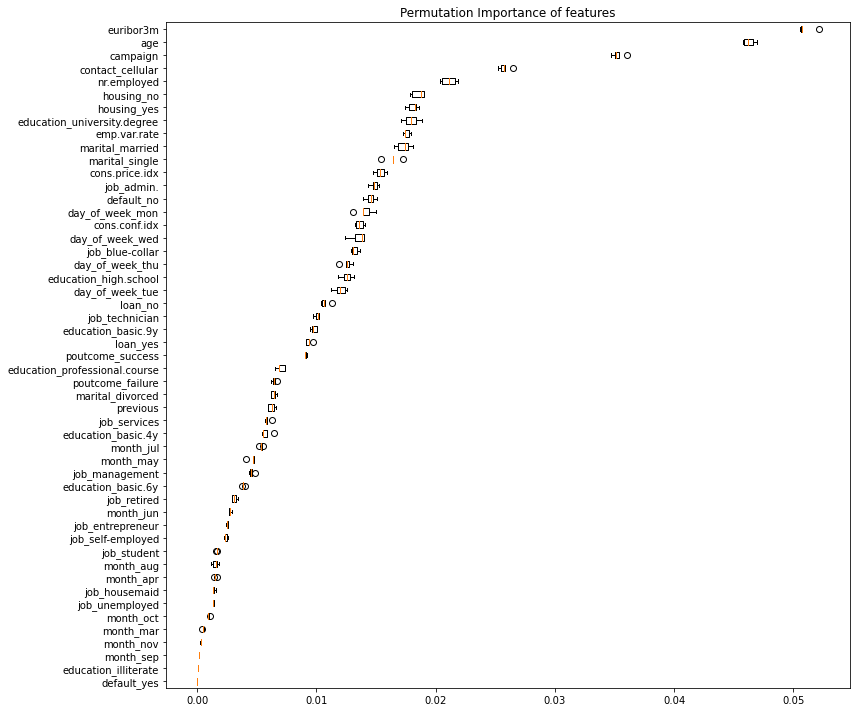

In [24]:
fig, ax = plt.subplots(figsize = (12,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importance of features")
fig.tight_layout()
plt.show()

In [25]:
features_selected = list(X_train.columns[result.importances_mean > 0.01])
features_imp = list(X_train.columns[sorted_idx][-10:])[::-1]
X_train = X_train.loc[:, features_selected]
X_test = X_test.loc[:, features_selected]

# Inferential Analysis


## Important factors impacting term deposit conversion

In [26]:
features_imp

['euribor3m',
 'age',
 'campaign',
 'contact_cellular',
 'nr.employed',
 'housing_no',
 'housing_yes',
 'education_university.degree',
 'emp.var.rate',
 'marital_married']

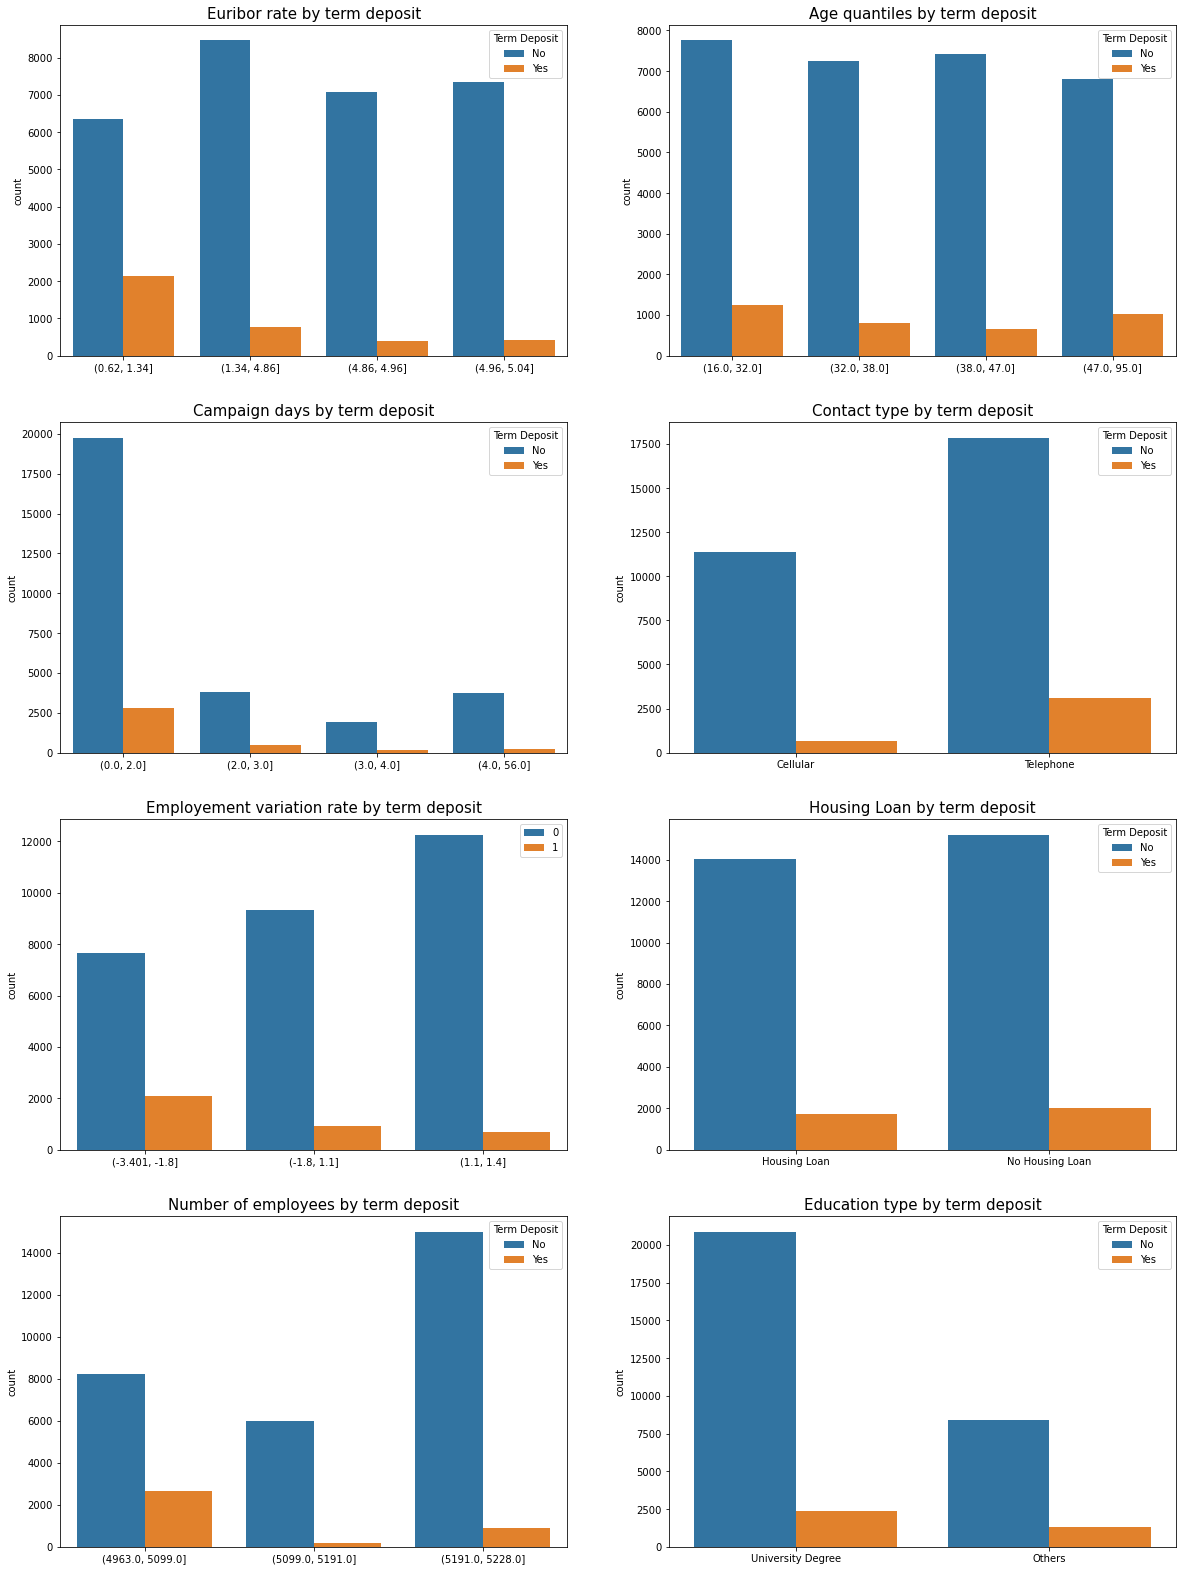

In [27]:
fig, ax = plt.subplots(4,2, figsize=(20,28))

quantiles = pd.qcut(X_train['euribor3m'], q= 4, precision = 0)
s0 = sns.countplot(quantiles, hue = y_train, ax = ax[0][0])
s0.set_xlabel(None)
s0.set_title("Euribor rate by term deposit",fontsize=15)
s0.legend(["No", "Yes"], title ="Term Deposit");

quantiles = pd.qcut(X_train['age'], q=4, precision = 0)
s1 = sns.countplot(quantiles, hue = y_train, ax = ax[0][1])
s1.set_xlabel(None)
s1.set_title("Age quantiles by term deposit",fontsize=15)
s1.legend(["No", "Yes"], title ="Term Deposit");

quantiles = pd.qcut(X_train['campaign'], q=8, precision = 0, duplicates = "drop")
s2 = sns.countplot(quantiles, hue = y_train, ax = ax[1][0])
s2.set_xlabel(None)
s2.set_title("Campaign days by term deposit",fontsize=15)
s2.legend(["No", "Yes"], title ="Term Deposit");

s3 = sns.countplot(X_train["contact_cellular"], hue = y_train, ax = ax[1][1])
s3.set_xlabel(None)
s3.set_xticklabels(["Cellular", "Telephone"])
s3.set_title("Contact type by term deposit",fontsize=15)
s3.legend(["No", "Yes"], title ="Term Deposit");

quantiles = pd.qcut(X_train['emp.var.rate'], q=4,duplicates = "drop")
s4 = sns.countplot(quantiles, hue = y_train, ax = ax[2][0])
s4.set_xlabel(None)
s4.set_title("Employement variation rate by term deposit",fontsize=15)


s5 = sns.countplot(X_train["housing_yes"], hue = y_train, ax = ax[2][1])
s5.set_xlabel(None)
s5.set_xticklabels(["Housing Loan", "No Housing Loan"])
s5.set_title("Housing Loan by term deposit",fontsize=15)
s5.legend(["No", "Yes"], title ="Term Deposit");


quantiles = pd.qcut(X_train['nr.employed'], q= 4,duplicates = "drop", precision = 0)
s6 = sns.countplot(quantiles, hue = y_train, ax = ax[3][0])
s6.set_xlabel(None)
s6.set_title("Number of employees by term deposit",fontsize=15)
s6.legend(["No", "Yes"], title ="Term Deposit");

s7 = sns.countplot(X_train["education_university.degree"], hue = y_train, ax = ax[3][1])
s7.set_xlabel(None)
s7.set_xticklabels(["University Degree", "Others"])
s7.set_title("Education type by term deposit",fontsize=15)
s7.legend(["No", "Yes"], title ="Term Deposit");

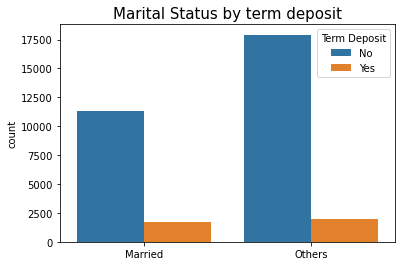

In [28]:
plt.figure(figsize = (6,4))
s8 = sns.countplot(X_train["marital_married"], hue = y_train)
s8.set_xlabel(None)
s8.set_xticklabels(["Married", "Others"])
s8.set_title("Marital Status by term deposit",fontsize=15)
s8.legend(["No", "Yes"], title ="Term Deposit");

**Observations:** <br>
- **Euribor rate is low** there is higher chance of term deposit <br>
- **Older age** people have slighly higher chance of term deposit <br>
- **Telephone** contact type has higher chance of term deposit <br>
- **Lower employment variation rate** higher the chance of term deposit <br>
- **Lesser number of employees** higher the chance of term deposit <br> 
- **Married people have higher chance** of having a term deposit <br>

# Predictive Modeling 

In this section, we build models so as to predict whether a call would result into a subscription of term deposit based on the selected attributes
<br>

Metric:
- Precision-Recall AUC: Area under the curve, more the area better it is 
- F1-Score: Harmonic mean of precision and recall as defined above <br>


Steps: 
- Fit training data
- Tune hyperparameters to get a good area under the curve
- Compare different models in terms of area under the curve 

## Defining Metrics

In [29]:
def pr_auc(y, probabilities):
    precision, recall, _ = precision_recall_curve(y, probabilities)
    return auc(recall, precision)

In [86]:
def max_f1(precision, recall):
    max_f1 = 0
    for p,r in zip(precision, recall):
        if (p+r) == 0:
            f1_score = 0
        else:
            f1_score = 2*p*r / (p+r)
        if max_f1 < f1_score:\
            max_f1 = f1_score
    return max_f1

## Normalizing Data

In [87]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)

## Models 

### Null model
Baseline model: This serves as a comparison for other models. We predict randomly based on the probability of the class we have from the input as a bernoulli trial

In [88]:
summary = pd.DataFrame(columns = ["Model", "PR-AUC", "F1-Score"])
base_0 = np.random.binomial(1, np.mean(y_train), size = len(y_test))
preds = base_0

In [89]:
null_precision, null_recall, _ = precision_recall_curve(y_test, base_0)
auc_score = np.round(auc(null_recall, null_precision),2)
f1 = np.round(max_f1(null_precision, null_recall),2)

In [90]:
summary = summary.append({"Model":"Null","PR-AUC": auc_score, "F1-Score":f1}, ignore_index=  True)

In [91]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.2


### Decision Tree 

In [92]:
param_grid = {"max_depth": [2,5,10,20], "ccp_alpha":[0,0.1,0.5]}

In [93]:
dt = DecisionTreeClassifier()
gs_model = GridSearchCV(dt,param_grid, scoring = make_scorer(pr_auc), cv = 5)
gs_model.fit(X_train_n, y_train)
dt.set_params(**gs_model.best_params_)
dt.fit(X_train_n, y_train);

In [94]:
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt.predict_proba(X_test_n)[:,1])
auc_score = np.round(auc(dt_recall, dt_precision),2)
f1 = np.round(max_f1(dt_precision, dt_recall),2)

In [95]:
summary = summary.append({"Model":"Decision Tree","PR-AUC": auc_score,"F1-Score":f1}, ignore_index=  True)

In [96]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.20
1,Decision Tree,0.48,0.46


### Logistic Regression 

In [97]:
param_grid = {"C":[0.1,0.5,1,2,5], "penalty":["l2"]}

In [98]:
lr = LogisticRegression(max_iter = 1000)
gs_model = GridSearchCV(lr, param_grid, scoring = make_scorer(pr_auc), cv = 5)
gs_model.fit(X_train_n, y_train)
lr.set_params(**gs_model.best_params_)
lr.fit(X_train_n, y_train);

In [100]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr.predict_proba(X_test_n)[:,1])
auc_score = np.round(auc(lr_recall, lr_precision),2)
f1 = np.round(max_f1(lr_precision, lr_recall),2)

In [101]:
summary = summary.append({"Model":"Logistic Regression","PR-AUC": auc_score,"F1-Score":f1}, ignore_index=  True)

In [102]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.20
1,Decision Tree,0.48,0.46
2,Logistic Regression,0.40,0.47


### Random Forest

In [103]:
param_grid = {"max_depth":[1,2,5,10,20,None], "max_features": ["sqrt", "log2"]}

In [104]:
rf = RandomForestClassifier()
gs_model = GridSearchCV(rf, param_grid, scoring = make_scorer(pr_auc), cv = 5)
gs_model.fit(X_train_n, y_train)
rf.set_params(**gs_model.best_params_)
rf.fit(X_train_n, y_train);

In [105]:
gs_model.best_params_

{'max_depth': 1, 'max_features': 'sqrt'}

In [106]:
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf.predict_proba(X_test_n)[:,1])
auc_score = np.round(auc(rf_recall, rf_precision),2)
f1 = np.round(max_f1(rf_precision, rf_recall),2)

In [107]:
summary = summary.append({"Model":"Random Forest","PR-AUC": auc_score,"F1-Score":f1}, ignore_index=  True)

In [108]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.20
1,Decision Tree,0.48,0.46
2,Logistic Regression,0.40,0.47
3,Random Forest,0.35,0.48


### AdaBoost

In [109]:
param_grid = {"n_estimators":[50,100],"learning_rate": [0.1, 0.2, 0.5,1,2,5]}

In [110]:
ab = AdaBoostClassifier()
gs_model = GridSearchCV(ab, param_grid, scoring = make_scorer(pr_auc), cv = 5)
gs_model.fit(X_train_n, y_train)
ab.set_params(**gs_model.best_params_)
ab.fit(X_train_n, y_train);

In [111]:
ab_precision, ab_recall, _ = precision_recall_curve(y_test, ab.predict_proba(X_test_n)[:,1])
auc_score = np.round(auc(ab_recall, ab_precision),2)
f1 = np.round(max_f1(ab_precision, ab_recall),2)

In [112]:
summary = summary.append({"Model":"AdaBoost","PR-AUC": auc_score,"F1-Score":f1}, ignore_index=  True)

In [113]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.20
1,Decision Tree,0.48,0.46
2,Logistic Regression,0.40,0.47
3,Random Forest,0.35,0.48
4,AdaBoost,0.49,0.46


### K Nearest Neighbors

In [114]:
param_grid = {"n_neighbors": [2,3,5,10,20]}

In [115]:
knn = KNeighborsClassifier()
gs_model = GridSearchCV(knn, param_grid, scoring = make_scorer(pr_auc), cv = 5)
gs_model.fit(X_train_n, y_train)
knn.set_params(**gs_model.best_params_)
knn.fit(X_train_n, y_train);

In [116]:
gs_model.best_params_

{'n_neighbors': 5}

In [117]:
knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn.predict_proba(X_test_n)[:,1])
auc_score = np.round(auc(knn_recall, knn_precision),2)
f1 = np.round(max_f1(knn_precision, knn_recall),2)

In [118]:
summary = summary.append({"Model":"K-Nearest Neighbors","PR-AUC": auc_score,"F1-Score":f1}, ignore_index=  True)

In [119]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.20
1,Decision Tree,0.48,0.46
2,Logistic Regression,0.40,0.47
3,Random Forest,0.35,0.48
4,AdaBoost,0.49,0.46
5,K-Nearest Neighbors,0.30,0.37


### XGBoost

In [120]:
param_grid = {"eta": [0.001,0.01, 0.05,0.1,0.5],"max_depth" : [3,5,10]}

In [121]:
xgb = XGBClassifier()
gs_model = GridSearchCV(xgb, param_grid, scoring = make_scorer(pr_auc), cv = 5)
gs_model.fit(X_train_n, y_train)
xgb.set_params(**gs_model.best_params_)
xgb.fit(X_train_n, y_train);

In [122]:
gs_model.best_params_

{'eta': 0.001, 'max_depth': 5}

In [123]:
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb.predict_proba(X_test_n)[:,1])
auc_score = np.round(auc(xgb_recall, xgb_precision),2)
f1 = np.round(max_f1(xgb_precision, xgb_recall),2)

In [124]:
summary = summary.append({"Model":"XGBoost","PR-AUC": auc_score,"F1-Score":f1}, ignore_index=  True)

In [125]:
summary

,Model,PR-AUC,F1-Score
0,Null,0.16,0.20
1,Decision Tree,0.48,0.46
2,Logistic Regression,0.40,0.47
3,Random Forest,0.35,0.48
4,AdaBoost,0.49,0.46
5,K-Nearest Neighbors,0.30,0.37
6,XGBoost,0.43,0.50


## Summarizing Outputs 

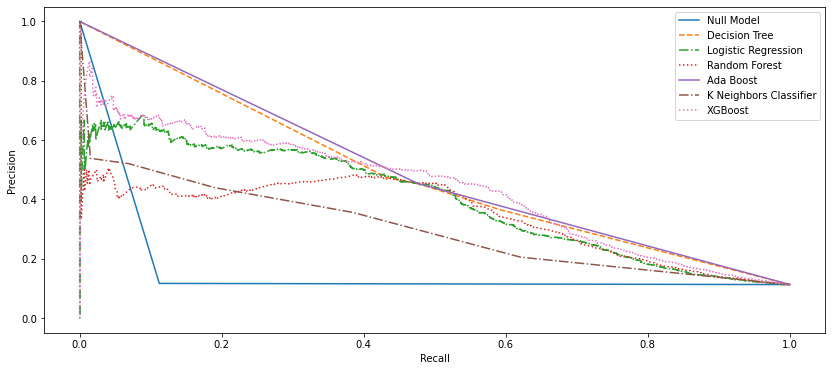

In [127]:
plt.figure(figsize = (14,6))

plt.plot(null_recall, null_precision, linestyle = "-", markerfacecolor = "w", label = "Null Model")

plt.plot(dt_recall, dt_precision, linestyle = "--", markerfacecolor = "b", label = "Decision Tree")

plt.plot(lr_recall, lr_precision, linestyle = "-.", markerfacecolor = "g", label = "Logistic Regression")

plt.plot(rf_recall, rf_precision, linestyle = ":", markerfacecolor = "c", label = "Random Forest")

plt.plot(ab_recall, ab_precision, linestyle = "solid", markerfacecolor = "m", label = "Ada Boost")

plt.plot(knn_recall, knn_precision, linestyle = "dashdot", markerfacecolor = "y", label = "K Neighbors Classifier")

plt.plot(xgb_recall, xgb_precision, linestyle = "dotted", markerfacecolor = "k", label = "XGBoost")


plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision');

Observations:
- AdaBoost perfoms the best overall
- XGBoost has the highest F1-Score of 0.6
- All the models perform better than the Null Model